### This file is for the user to apply our damping technique to a problem of their choosing. We include an example for how it can be used to solve the Korteweg-de Vries equation at the end.

In [1]:
using FFTW, Plots, LinearAlgebra, SparseArrays, Printf, CSV, DataFrames
import Base: diff

rnd = xx -> map(x -> round(x, digits = 5),xx)
mfftshift = x -> circshift(fftshift(x), isodd(length(x)) ? 1 : 0)
# Fourier Transform:
mfft = x -> fftshift(fft(fftshift(x),1)) # fft(x,1) is used so that
# when we operate on matrices below, the behavior is as desired.
# Inverse Fourier transform:
mifft = x -> mfftshift(ifft(mfftshift(x),1))
# Helper method:
mgrid = (n,L) -> -L .+ 2*L*(0:n-1)/n # array from -L to L leaving out L

#11 (generic function with 1 method)

### Functions

In [2]:
# We use this when solving the heat equation with Strang-splitting:
function CG(A,b,eps::Float64)
   x = 0.0*b; r = b; p = r; n = 0;
   while norm(r) > eps
        q = A(p)
        a = (r'*r)/(p'*q)
        x += a*p
        r_old = r
        r += - a*q
        b = (r'*r)/(r_old'*r_old)
        p = r + b*p 
        n += 1
    end
    x
end

CG (generic function with 1 method)

In [3]:
# Fourth-order Runge-Kutta method:
function rk4(a, t, dt) 
    f1 = exp(M * t) * F(exp(-M * t) * a)
    f2 = exp(M * (t+dt/2)) * F(exp(-M * (t+dt/2)) * (a+(dt/2)*f1))
    f3 = exp(M * (t+dt/2)) * F(exp(-M * (t+dt/2)) * (a+(dt/2)*f2))
    f4 = exp(M * (t+dt)) * F(exp(-M * (t+dt)) * (a+dt*f3))
    a = a + (dt/6)*(f1+2*f2+2*f3+f4)
    return a
end

rk4 (generic function with 1 method)

In [4]:
#= We use this when we have an aperiodic initial condition with a periodic spatial derivative:
    -input: vector c of Fourier coefficients of a function
            variables defined outside of function: L,c_,n,X,m,iD
    -output: vector q of function values of the antiderivative of the function =#
function integrate(c)
    ind = findfirst(n .== 0)
    S = iD*c
    q = c[ind]/m .* (X .+ L) + mifft(S)
    q = q .- q[1] .+ c_
    return q
end

integrate (generic function with 1 method)

### Specify functions and parameters based on your problem

In [ ]:
# Define the domain:
L = # interval of computation is [-L, L]
m = # number of grid points
X = mgrid(m, L)

if isodd(m)
    n = (1-length(X))./2 .+ (0:(length(X)-1))
else
    n = -1 .* length(X) ./ 2 .+ (0:(length(X)-1))
end

D = (pi/L) * Diagonal(1im.*n);

#= The following lines of code are only necessary if we have an aperiodic IC with a periodic derivative and are 
   therefore going to use the integrate function above. You can comment them out otherwise. =#
ind = findfirst(n .== 0)
iD = copy(D)
iD[ind,ind] = 1.0
iD = inv(iD)
iD[ind,ind] = 0.0;

In [ ]:
# Define M and F (from section 3) based on the PDE:
M = # matrix that represents a linear combination of spatial derivatives
F = c -> # a function of Fourier coefficients that represents the nonlinearity in the PDE

In [ ]:
# Specify an initial condition:
q0 = x -> # IC
c = mfft(q0(X));

#= The following lines of code are only necessary if we have an aperiodic IC with a periodic derivative.
   Comment them out otherwise. =#
q0_prime = x - > # derivative of IC
c_ = # the value of q0 at -L
c = mfft(q0_prime(X));

### Choose damping parameters

In [ ]:
k_1 = # heat eq. damping coefficient
f_1 = # freq. of heat eq. damping
f_2 = # freq. of exponential decay damping

σ = x ->
γ = x ->

#= The following lines of code are only necessary is heat equation damping is being used. Comment them
   out otherwise. =#
Σ = Diagonal(σ(X))
A = x -> x + (dt/2)*D*mfft(Σ*mifft(D*x))
B = x -> x - (dt/2)*D*mfft(Σ*mifft(D*x))

### Compute your solution

In [ ]:
dt = # time step
T = # final time
t = 0.0
steps = convert(Int64,ceil(T/dt))
a = c

for i = 1:steps+1   
    if isinteger(i / f_1)
        # Heat equation with Strang-splitting:
        a = rk4(c,dt/2,dt/2)
        c_til = exp(-M*dt/2) * a
        c_bar = CG(B, A(c_til), 1e-10)
        a = rk4(c_bar,dt/2,dt/2)
        c = exp(-M*dt/2) * a
    else
        a = rk4(c,dt,dt)
        c = exp(-M*dt) * a
    end
    
    if isinteger(i / f_2)
        # Exponential decay:
        func_vals = mifft(c) .* γ(X)
        c = mfft(func_vals)
    end
    
    t += dt
end

final_solution = mifft(c) |> real;

#= The following line of code is only necessary if we have an aperiodic IC with a periodic derivative.
   Comment it out otherwise. =#
final_solution = integrate(c) |> real;

plot(X, final_solution, label = false)

## Example: Solving the Korteweg-de Vries equation

In [5]:
# Define the domain:
L = 200
m = 2^10
X = mgrid(m, L)

if isodd(m)
    n = (1-length(X))./2 .+ (0:(length(X)-1))
else
    n = -1 .* length(X) ./ 2 .+ (0:(length(X)-1))
end

D = (pi/L) * Diagonal(1im.*n);

In [6]:
# Define M and F (from section 3) based on the PDE:
M = D.^3
F = c -> (-6) .* mfft(mifft(c) .* mifft(D*c));

In [7]:
# Specify an initial condition:
q0 = x -> 1.3 * exp.(-x.^2)
c = mfft(q0(X));

In [11]:
k_1 = 1
f_1 = 1
f_2 = 1000

ℓ1 = -L + (L/2) - 10
ℓ2 = L
σ = x -> 1 .- (0.5.*(tanh.((x.-ℓ1)) .+ 1) + 0.5.*(tanh.((-x.-ℓ2)) .+ 1))
γ = x -> 1 .- σ(-x)

Σ = Diagonal(σ(X))
A = x -> x + (dt/2)*D*mfft(Σ*mifft(D*x))
B = x -> x - (dt/2)*D*mfft(Σ*mifft(D*x));

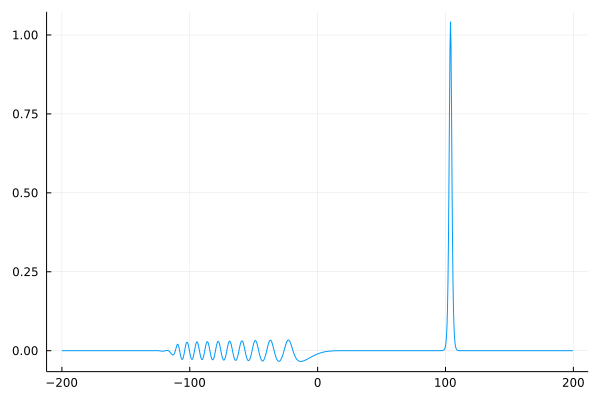

In [12]:
dt = 0.01
T = 50
t = 0.0
steps = convert(Int64,ceil(T/dt))
a = c

for i = 1:steps+1   
    if isinteger(i / f_1)
        # Heat equation with Strang-splitting:
        a = rk4(c,dt/2,dt/2)
        c_til = exp(-M*dt/2) * a
        c_bar = CG(B, A(c_til), 1e-10)
        a = rk4(c_bar,dt/2,dt/2)
        c = exp(-M*dt/2) * a
    else
        a = rk4(c,dt,dt)
        c = exp(-M*dt) * a
    end
    
    if isinteger(i / f_2)
        # Exponential decay:
        func_vals = mifft(c) .* γ(X)
        c = mfft(func_vals)
    end
    
    t += dt
end

final_solution = mifft(c) |> real;
plot(X, final_solution, label = false)